In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import tarfile
import urllib
import matplotlib.pyplot as plt
import pydicom as dicom
import os
# import gdcm
from tqdm.notebook import trange, tqdm


def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
train_df = load_metadata()

In [3]:
np.version.version


'2.2.2'

In [4]:
label = ["Abdomen",
         "Ankle",
         "Cervical Spine",
         "Chest",
         "Clavicles",
         "Elbow",
         "Feet",
         "Finger",
         "Forearm",
         "Hand",
         "Hip",
         "Knee",
         "Lower Leg",
         "Lumbar Spine",
         "Others",
         "Pelvis",
         "Shoulder",
         "Sinus",
         "Skull",
         "Thigh",
         "Thoracic Spine",
         "Wrist"]
train_df["Name"] = [label[int(x.split(" ")[0])] for x in train_df["Target"]]
train_df.head(5)

,SOPInstanceUID,Target,Name
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,Abdomen
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,Pelvis
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,Lower Leg
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,Others
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,Chest


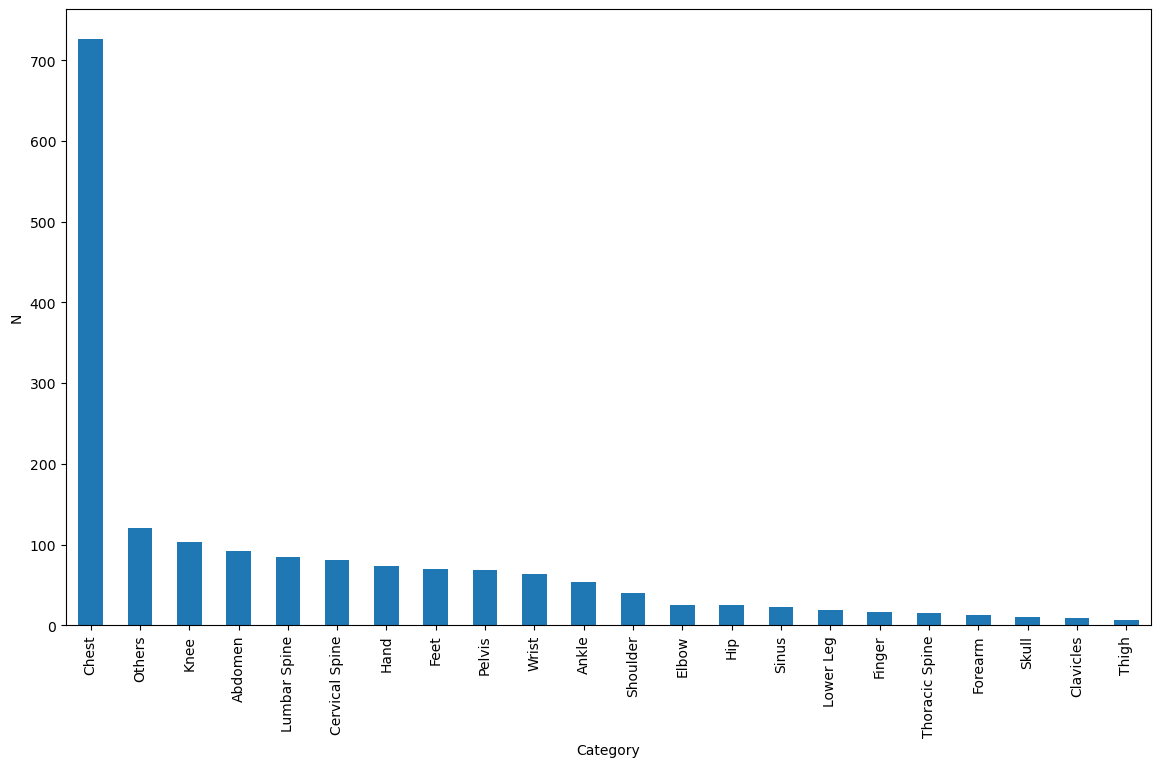

In [5]:
ax = train_df['Name'].value_counts().plot(kind='bar',
                                    figsize=(14,8))
ax.set_xlabel("Category")
ax.set_ylabel("N")
plt.show()

In [6]:
def find_all(name, path="data/train/"):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    if len(result) == 1:
        return result[0]
    elif len(result) == 0:
        print(f'not found : {name}')
    else :
        print("More that one pic")
        print(result)

find_all("1.2.826.0.1.3680043.8.498.11373167214629703280194450289801864281-c.dcm")

'data/train/1025/1.2.826.0.1.3680043.8.498.11165434136293257355747581429615907664/1.2.826.0.1.3680043.8.498.32759359642479518732575675906322937976/1.2.826.0.1.3680043.8.498.11373167214629703280194450289801864281-c.dcm'

In [7]:
string = './test '
folder = "train"
string = string + f'./{folder} '
for lab in label:
    string = string + f'./{folder}/"{lab}" '
string

'./test ./train ./train/"Abdomen" ./train/"Ankle" ./train/"Cervical Spine" ./train/"Chest" ./train/"Clavicles" ./train/"Elbow" ./train/"Feet" ./train/"Finger" ./train/"Forearm" ./train/"Hand" ./train/"Hip" ./train/"Knee" ./train/"Lower Leg" ./train/"Lumbar Spine" ./train/"Others" ./train/"Pelvis" ./train/"Shoulder" ./train/"Sinus" ./train/"Skull" ./train/"Thigh" ./train/"Thoracic Spine" ./train/"Wrist" '

In [8]:
!mkdir $string


mkdir: ./test: File exists
mkdir: ./train: File exists
mkdir: ./train/Abdomen: File exists
mkdir: ./train/Ankle: File exists
mkdir: ./train/Cervical Spine: File exists
mkdir: ./train/Chest: File exists
mkdir: ./train/Clavicles: File exists
mkdir: ./train/Elbow: File exists
mkdir: ./train/Feet: File exists
mkdir: ./train/Finger: File exists
mkdir: ./train/Forearm: File exists
mkdir: ./train/Hand: File exists
mkdir: ./train/Hip: File exists
mkdir: ./train/Knee: File exists
mkdir: ./train/Lower Leg: File exists
mkdir: ./train/Lumbar Spine: File exists
mkdir: ./train/Others: File exists
mkdir: ./train/Pelvis: File exists
mkdir: ./train/Shoulder: File exists
mkdir: ./train/Sinus: File exists
mkdir: ./train/Skull: File exists
mkdir: ./train/Thigh: File exists
mkdir: ./train/Thoracic Spine: File exists
mkdir: ./train/Wrist: File exists


In [9]:
!ls train


Abdomen        Elbow          Hip            Pelvis         Thoracic Spine
Ankle          Feet           Knee           Shoulder       Wrist
Cervical Spine Finger         Lower Leg      Sinus
Chest          Forearm        Lumbar Spine   Skull
Clavicles      Hand           Others         Thigh


In [13]:
from PIL import Image, ImageOps


def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [14]:
for i in range(1,len(train_df)):
    target = train_df["Target"].iloc[i]
    if target.split(" ")[0] != target[:-1]:
        continue
    file = train_df["SOPInstanceUID"].iloc[i]
    file_path = find_all(f'{file}-c.dcm')

    ds = dicom.dcmread(file_path)
    
    normalized = ( ds.pixel_array - np.mean(ds.pixel_array) ) / np.std(ds.pixel_array)
    mat  = ( normalized + 1 ) /2
    img = Image.fromarray(np.uint8(mat * 255) , 'L')
    padded = resize_with_padding(img,(256,256))
    padded.save(f'./train/{label[int(target)]}/{i}.jpg')
    img